In [1]:
import numpy as np
import pandas as pd
import glob

journals_list = ['the_guardian', 'dailymail', 'bbc_news', 'the_telegraph']

Import Headlines

In [2]:
## Strip all the newlines and set letters lowercase
def strip_title(title):
    words = [word.strip().lower() for word in title.split()]   
    return " ".join(words)

## Load headlines into a Dataframe
def load_headlines_from_journal(journal_name):
    
    if journal_name == 'the_guardian':
        df = pd.DataFrame()
        for file in glob.glob('webpage_scraping/archive/'+journals_list[0]+'*'):
            df_read = pd.read_csv(file)
            df = pd.concat([df, df_read],sort=False, ignore_index=True)
        del df['Unnamed: 0']
    
    else:
        df = pd.DataFrame({'Title':[]})
        for file in glob.glob('webpage_scraping/archive/'+journal_name+'*'):
            df_read = pd.read_csv(file, names=['Title'], skiprows=[0])
            df = pd.concat([df, df_read],sort=False, ignore_index=True)
    
    df[df.isna()] = ' '
    for col in df.columns:
        df[col] = df[col].apply(lambda x: strip_title(x)) 
    df = df.drop_duplicates()
    return df

### Import the headlines 

In [3]:
guardian_sec = load_headlines_from_journal('the_guardian')
dailymail = load_headlines_from_journal('dailymail')
bbc_news = load_headlines_from_journal('bbc_news')
the_telegraph = load_headlines_from_journal('the_telegraph')

In [4]:
# Merge all the sections of the guardian togheter
the_guardian = pd.DataFrame(columns=['Title', 'Section'])

for column in guardian_sec.columns:
    df = pd.DataFrame({'Title': guardian_sec[column], 'Section': column})
    the_guardian = the_guardian.append(df, ignore_index=True)

In [5]:
# drop null values
bbc_news = bbc_news[bbc_news.Title != '']
the_guardian = the_guardian[the_guardian.Title != '']

Import the __clickbait classifier__ and the __preprocessing tools__.

In [6]:
from joblib import load
from preprocessing import full_pipeline

clf = load('trained_clf_v2.joblib')

dailymail_prep = full_pipeline.transform(dailymail['Title'])
bbc_news_prep = full_pipeline.transform(bbc_news['Title'])
telegraph_prep = full_pipeline.transform(the_telegraph['Title'])
guardian_prep = full_pipeline.transform(the_guardian['Title'])

Dictionary loaded.


### 1. Total Clickbait Ratio

Predict the probability of being clickbait

In [7]:
dailymail['Probability'] = clf.predict_proba(dailymail_prep)[:,1]
bbc_news['Probability'] = clf.predict_proba(bbc_news_prep)[:,1]
the_telegraph['Probability'] = clf.predict_proba(telegraph_prep)[:, 1]
the_guardian['Probability'] = clf.predict_proba(guardian_prep)[:,1]

In [8]:
dfs_list = [the_guardian, dailymail, bbc_news, the_telegraph]
tot_headlines = pd.DataFrame(columns=['Title', 'Probability', 'Journal'])

for df, name in zip(dfs_list, journals_list):
    df['Journal'] = [name]*len(df)
    tot_headlines = tot_headlines.append(df[['Title', 'Probability', 'Journal']], ignore_index=True)

In [9]:
n_clickbait = len(tot_headlines[tot_headlines['Probability']>0.5])
print('Total Clickbait ratio: {}'.format(np.round(n_clickbait/len(tot_headlines), 2)))

Total Clickbait ratio: 0.22


In [10]:
pd.set_option('display.max_colwidth', -1)

tot_headlines.sort_values('Probability', ascending=False).head()

,Title,Probability,Journal
2498,three things you might not know about queen victoria,0.988150,bbc_news
3439,10 forgotten english villages you'd never thought to visit,0.966571,the_telegraph
2539,four numbers that explain why trump was cleared,0.956895,bbc_news
504,10 talking points from the weekend’s action,0.953749,the_guardian
469,10 talking points from the weekend action,0.953749,the_guardian


## 2. Clickbait ratio per journal

In [11]:
clckbt_pct = np.zeros(4)

for index, df in enumerate(dfs_list):
    clckbt_pct[index] = 100 * np.round(len(df[df['Probability']>.5])/len(df), 3)
    
clckbt_pct

array([18.1, 12.4, 21.8, 33. ])

Saving figure clckbt_ratio_uk_j


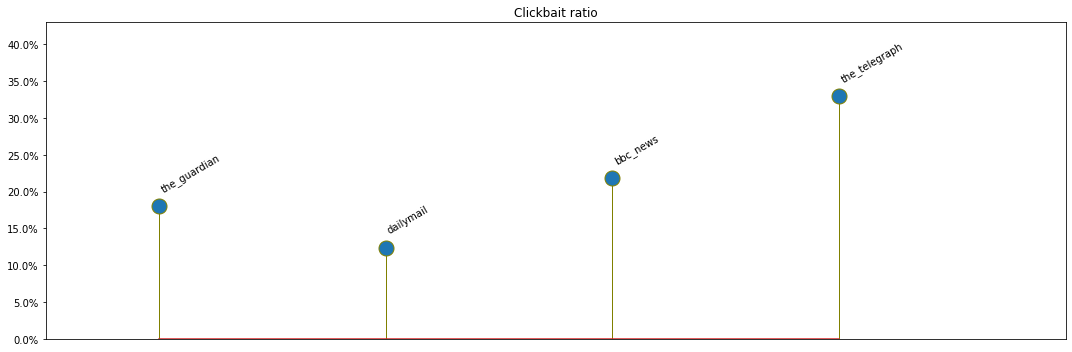

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt
from utilities import save_fig

fig = plt.figure(figsize=(15,5))
ax = plt.axes()
(markers, stemlines, baseline) = ax.stem(journals_list, clckbt_pct, use_line_collection=True)

plt.setp(markers, marker='o', markersize=15, markeredgecolor="olive", markeredgewidth=1)
plt.setp(stemlines, linestyle="-", color="olive", linewidth=1)

# x - axis
ax.axes.get_xaxis().set_visible(False)
ax.axes.set_xlim((-.5, len(clckbt_pct)))

# y - axis
y_max = max(clckbt_pct)+10
ax.axes.set_ylim((0, y_max))
old_ticks = ax.axes.get_yticks()
ticks_labels = ['{}%'.format(digit) for digit in old_ticks]
ax.axes.set_yticklabels(ticks_labels)
ax.axes.set_title('Clickbait ratio')

for index, journal in enumerate(journals_list):
    ax.annotate(journal, xy=(index, clckbt_pct[index]+2), annotation_clip=False, rotation=30)

save_fig('clckbt_ratio_uk_j')
plt.show()

### 3. The guardian Sections

In [13]:
sections = guardian_sec.columns
clckbt_sec_ratios = np.zeros(len(sections))

for index, section in enumerate(sections):
    df = the_guardian[the_guardian['Section']==section]
    clckbt_sec_ratios[index] = np.round(len(df[df['Probability']>.5])/len(df), 2)
    print(section+': {}'.format(clckbt_sec_ratios[index]))

Headlines: 0.08
Spotlight: 0.35
Opinion: 0.33
Sport: 0.11
From the UK: 0.03
Around the world: 0.08
Culture: 0.28
Lifestyle: 0.43
Explore: 0.25
In pictures: 0.12
Most viewed: 0.18


Saving figure clckbt_ratio_guardian


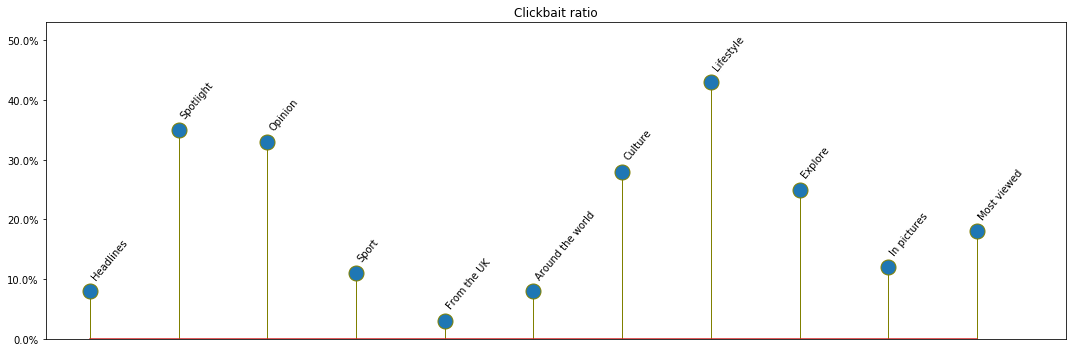

In [14]:
fig = plt.figure(figsize=(15,5))
ax = plt.axes()
(markers, stemlines, baseline) = ax.stem(sections, clckbt_sec_ratios*100, use_line_collection=True)

plt.setp(markers, marker='o', markersize=15, markeredgecolor="olive", markeredgewidth=1)
plt.setp(stemlines, linestyle="-", color="olive", linewidth=1)

# x - axis
ax.axes.get_xaxis().set_visible(False)
ax.axes.set_xlim((-.5, len(clckbt_sec_ratios)))

# y - axis
y_max = max(100*clckbt_sec_ratios)+10
ax.axes.set_ylim((0, y_max))
old_ticks = ax.axes.get_yticks()
ticks_labels = ['{}%'.format(digit) for digit in old_ticks]
ax.axes.set_yticklabels(ticks_labels)
ax.axes.set_title('Clickbait ratio')

for index, section in enumerate(sections):
    ax.annotate(section, xy=(index, 100*clckbt_sec_ratios[index]+2), annotation_clip=False, rotation=50)

save_fig('clckbt_ratio_guardian')
plt.show()